## Pablo Valdunciel Sánchez 
## 30th December, 2019

# Imports

In [4]:
import pandas as pd
import numpy as np
import keras.backend as K 
from keras import optimizers
from keras.models import Sequential 
from keras.layers import SimpleRNN, Dense, GRU, LSTM
import keras.losses, keras.optimizers

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Data preparation

In [5]:
SEQ_LEN = 20 
HOLD_OUT = 0.66
X_MAX = 15 

def split_sequence(sequence, n_steps):
    X = []
    Y = []
    num_records = len(sequence) - n_steps

    for i in range(num_records):
        X.append(sequence[i:i+n_steps])
        Y.append(sequence[i+n_steps])
        
    return np.array(X),np.array(Y)

In [6]:
# Read file containing the stock values 
data = pd.read_excel('.data/historica Iberdrola DIC 16-19.xls', dtype={'Fecha': str, 'Último': float}).values 

# Reverse the data set so that mos ancient values go first 
data = np.flip(data, axis=0)

# Separate dates and stock_vales
dates = data[:,0]
stock_values = data[:,1]

# Split the sequence
X,Y = split_sequence(stock_values, SEQ_LEN)

# Scale the stock_values 
X = X / X_MAX 
Y = Y / X_MAX 

# Adjust dimensions
X = np.expand_dims(X, axis=2)
Y = np.expand_dims(Y, axis=1)

# Get train and test sets (Holdout)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=(1-HOLD_OUT), random_state=2) 

# LSTM class

In [9]:
class MyLSTM:
    """MyLSTM class"""
    
    margin = 0.02
    
    def __init__(self, T, n_features, layer_sizes, layer_activations, 
                optimizer="adam", loss="mse", epochs=100, margin=0.02, verbose=1):
        """Constructor. Constructs a Simple RNN network with the especified parameters."""
        
        if len(layer_sizes) != 2: 
            raise AttributeError("layer_sizes must contain 2 elements")
            
        if len(layer_activations) != 2: 
            raise AttributeError("layer_activations must contain 2 elements")
            
        self.T = T             
        self.n_features = n_features
        self.layer_sizes = layer_sizes
        self.layer_activations = layer_activations
        self.epochs = epochs
        self.optimizer = optimizer
        self.loss = loss
        MyLSTM.margin = margin
        self.verbose = verbose       
        self.__model = None 
        self.__history = None
        
        self.__construct_model()
        print(self)
    
    
    @staticmethod
    def percentage_margin(y_true, y_pred):
        """Metric used in the training"""
        
        yy = K.sum(K.cast(K.less(K.abs((y_pred/y_true)-1.0), MyLSTM.margin), dtype=float))
        return yy / K.cast(K.shape(y_pred)[0], dtype=float)
    
    
    def __str__(self):
        """Provides a string representation of a MySimpleRNN instance"""
        
        return "MyLSTM(T={}, n_features={}, layer_sizes={}, optimizer={}, loss={}, epochs={}, \
        margin={}, verbose={})\n".format(self.T, self.n_features, self.layer_sizes, self.optimizer, 
                                                        self.loss, self.epochs, MyLSTM.margin, self.verbose)
    
    
    def __construct_model(self):
        """Contructs the model and compiles it"""
        
        # Create model
        self.__model = Sequential()    
        
        # Add Input layer
        input_layer = LSTM(units = self.layer_sizes[0], 
                           activation = self.layer_activations[0],
                           return_sequences = False, 
                           input_shape = (self.T, self.n_features))
        self.__model.add(input_layer)
        
        
        # Add Output layer
        output_layer = Dense(units = self.layer_sizes[1],
                             activation = self.layer_activations[1])
        self.__model.add(output_layer)    
        
        # Compile model
        self.__model.compile(optimizer = self.optimizer, 
                             loss = self.loss, 
                             metrics = [MyLSTM.percentage_margin])    
        self.__model.summary()
        
        
    def get_history(self):
        """Get the history of the model"""
        return self.__history 
    
    
    def fit(self, x_train, x_test, y_train, y_test):
        """Fit the model with validation data"""
        self.__history = self.__model.fit(x_train, y_train, 
                                          epochs = self.epochs, 
                                          verbose = self.verbose, 
                                          validation_data = (x_test,y_test))
    
    
    def predict(self, X):
        """Predicts the value of next element of the given sequences"""
        
        predictions = self.__model.predict(X, verbose = self.verbose)
        return predictions
                                
        
    def print_hit_rate_evolution(self):
        """Prints a lineal plot showing the evolution of the hit rates (validation an training) along the epochs"""
        
        plt.plot(self.__history.epoch, self.__history.history['val_percentage_margin'], label = 'validation')
        plt.plot(self.__history.epoch, self.__history.history['percentage_margin'], label = "training")
        plt.legend()
        plt.title('LSTM')
        plt.ylabel('Hit rate')
        plt.xlabel('Epoch')
        plt.show()                                         

# Class testing

In [10]:
lstm = MyLSTM(T=SEQ_LEN, 
            n_features=1, 
            layer_sizes=[5,1], 
            layer_activations=["tanh", None], 
            epochs=150)
lstm.fit(x_train, x_test, y_train, y_test)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 5)                 140       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 146
Trainable params: 146
Non-trainable params: 0
_________________________________________________________________
MyLSTM(T=20, n_features=1, layer_sizes=[5, 1], optimizer=adam, loss=mse, epochs=150,         margin=0.02, verbose=1)


Train on 475 samples, validate on 245 samples
Epoch 1/150
475/475 [==============================] - 0s 626us/step - loss: 0.0571 - percentage_margin: 0.0000e+00 - val_loss: 0.0321 - val_percentage_margin: 0.0000e+00
Epoch 2/150
475/475 [==============================] - 0s 149us/step - loss: 0.0182 - percentage_margin: 0.0000e+00 - val_loss: 0.0044 - val_percentage_margin: 0.0000e+00
Epoch 3/150

Epoch 43/150
475/475 [==============================] - 0s 183us/step - loss: 8.3348e-05 - percentage_margin: 0.7269 - val_loss: 8.4866e-05 - val_percentage_margin: 0.6656
Epoch 44/150
475/475 [==============================] - 0s 173us/step - loss: 8.2696e-05 - percentage_margin: 0.7469 - val_loss: 8.5882e-05 - val_percentage_margin: 0.6910
Epoch 45/150
475/475 [==============================] - 0s 178us/step - loss: 8.2913e-05 - percentage_margin: 0.7102 - val_loss: 9.3187e-05 - val_percentage_margin: 0.6931
Epoch 46/150
475/475 [==============================] - 0s 179us/step - loss: 8.4291e-05 - percentage_margin: 0.7028 - val_loss: 8.4700e-05 - val_percentage_margin: 0.6871
Epoch 47/150
475/475 [==============================] - 0s 170us/step - loss: 8.5203e-05 - percentage_margin: 0.7149 - val_loss: 8.3025e-05 - val_percentage_margin: 0.6929
Epoch 48/150
475/475 [==============================] - 0s 175us/step - loss: 8.0673e-05 - percentage_margin: 0.7219 - val_loss: 8.2744e-05 

475/475 [==============================] - 0s 199us/step - loss: 7.3117e-05 - percentage_margin: 0.7668 - val_loss: 7.6152e-05 - val_percentage_margin: 0.7225
Epoch 138/150
475/475 [==============================] - 0s 166us/step - loss: 7.2613e-05 - percentage_margin: 0.7630 - val_loss: 7.4770e-05 - val_percentage_margin: 0.7321
Epoch 139/150
475/475 [==============================] - 0s 175us/step - loss: 7.1906e-05 - percentage_margin: 0.7606 - val_loss: 7.2112e-05 - val_percentage_margin: 0.7360
Epoch 140/150
475/475 [==============================] - 0s 163us/step - loss: 7.0947e-05 - percentage_margin: 0.7708 - val_loss: 7.2238e-05 - val_percentage_margin: 0.7381
Epoch 141/150
475/475 [==============================] - 0s 167us/step - loss: 7.4203e-05 - percentage_margin: 0.7644 - val_loss: 7.5739e-05 - val_percentage_margin: 0.7225
Epoch 142/150
475/475 [==============================] - 0s 154us/step - loss: 7.1428e-05 - percentage_margin: 0.7528 - val_loss: 7.3604e-05 - val_pe

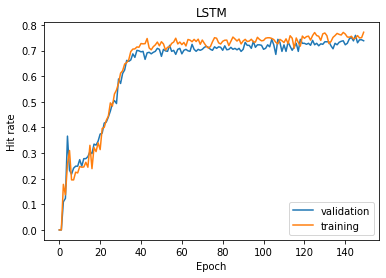

In [11]:
lstm.print_hit_rate_evolution()